# full code with new aug function / balanced classes / face detection and face landmarks 

In [1]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 42.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires protobuf<4,>3.12.2, but you have protobuf 4.25.3 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
google-cloud-

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from imgaug import augmenters as iaa
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import mediapipe as mp

2024-07-17 11:29:41.135483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 11:29:41.135582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 11:29:41.306628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [41]:
def load_images(root_dir):
    """
    Load images paths and labels into a DataFrame.
    """
    image_paths = []
    labels = []
    
    emotions = os.listdir(root_dir)
    for emotion in emotions:
        if os.path.isdir(os.path.join(root_dir, emotion)):
            for image_name in os.listdir(os.path.join(root_dir, emotion)):
                image_path = os.path.join(root_dir, emotion, image_name)
                image_paths.append(image_path)
                labels.append(emotion)
    
    df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    return df

def augment_images(df, output_dir, target_images_per_class=500):
    """
    Perform data augmentation using imgaug to ensure each class has a total of 500 images.
    """
    os.makedirs(output_dir, exist_ok=True)
    
    seq = iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-25, 25)),
        iaa.ShearX((-10, 10)),
        iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
        iaa.GaussianBlur(sigma=(0, 1.0)),
    ])
    
    augmented_paths = []
    class_counts = {label: 0 for label in df['label'].unique()}
    
    for index, row in df.iterrows():
        class_counts[row['label']] += 1
    
    for label, count in class_counts.items():
        if count < target_images_per_class:
            num_to_augment = target_images_per_class - count
            augment_factor = num_to_augment // count
            extra_augment = num_to_augment % count

            for _, row in tqdm(df[df['label'] == label].iterrows(), total=count, desc=f"Augmenting images for {label}"):
                image_path = row['image_path']
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                for i in range(augment_factor):
                    augmented_image = seq(image=image)
                    augmented_image_path = os.path.join(output_dir, f"{os.path.basename(image_path).split('.')[0]}_{i}.jpg")
                    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                    augmented_paths.append((augmented_image_path, label))

                if extra_augment > 0:
                    augmented_image = seq(image=image)
                    augmented_image_path = os.path.join(output_dir, f"{os.path.basename(image_path).split('.')[0]}_extra.jpg")
                    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
                    augmented_paths.append((augmented_image_path, label))
                    extra_augment -= 1
    
    augmented_df = pd.DataFrame(augmented_paths, columns=['image_path', 'label'])
    return pd.concat([df, augmented_df]).reset_index(drop=True)

def prepare_data(df):
    """
    Prepare HOG features, facial landmarks, and corresponding labels for training.
    """
    X_hog = []
    X_landmarks = []
    y = []
    
    # Initialize Mediapipe FaceMesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh()

    for index, row in df.iterrows():
        image_path = row['image_path']
        class_name = row['label']
        
        if os.path.isfile(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                # Extract HOG features
                hog_features = extract_hog_features(image)
                X_hog.append(hog_features)
                
                # Detect facial landmarks
                landmarks = detect_landmarks(image, face_mesh)
                X_landmarks.append(landmarks)
                
                y.append(class_name)
            else:
                print(f"Error: Unable to read image '{image_path}'")
        else:
            print(f"Warning: '{image_path}' is not a valid file")
    
    # Release resources
    face_mesh.close()
    
    return np.array(X_hog), np.array(X_landmarks), np.array(y)

def extract_hog_features(image):
    """
    Extract HOG features from an image.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_features, _ = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
    return hog_features

def detect_landmarks(image, face_mesh):
    """
    Detect facial landmarks using Mediapipe FaceMesh.
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)

    landmarks = []
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            for landmark in face_landmarks.landmark:
                # Extract landmark coordinates (normalized)
                landmarks.extend([landmark.x, landmark.y, landmark.z])
    
    # If no landmarks detected, return a list of zeros
    if not landmarks:
        landmarks = [0] * (468 * 3)  # 468 landmarks, each with x, y, z
    
    return landmarks

In [4]:
root_dir = '/kaggle/input/ck-dataset'

# Load images paths and labels into DataFrame
df = load_images(root_dir)

# Split into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Augment images for training set
output_dir = '/kaggle/working/augmented_data2'
augmented_train_df = augment_images(train_df, output_dir)

Augmenting images for sadness: 100%|██████████| 66/66 [00:01<00:00, 36.38it/s]


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns


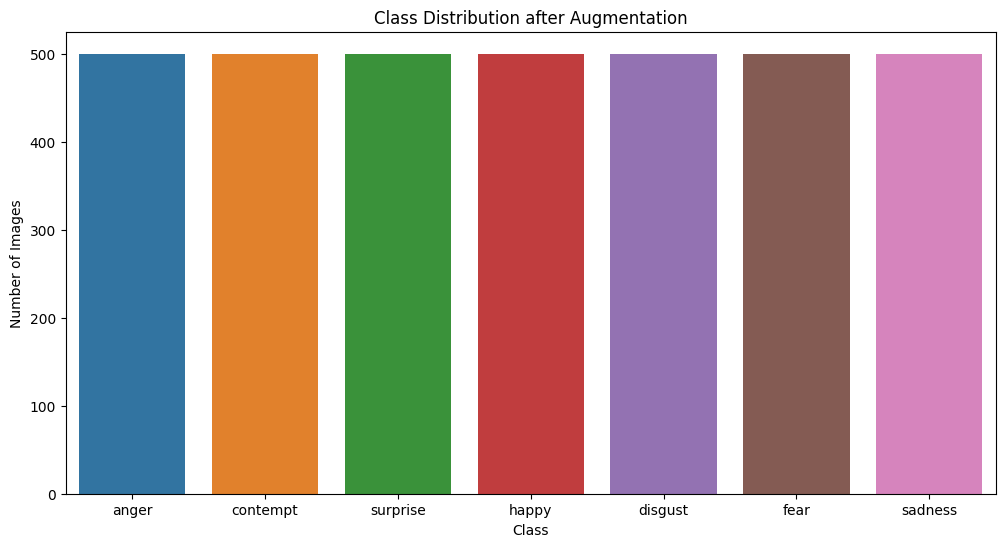

In [9]:
# Plot the distribution of each class
plt.figure(figsize=(12, 6))
sns.countplot(data=augmented_train_df, x='label')
plt.title('Class Distribution after Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [10]:
# Use landmarks in preparation step for augmented training data
X_hog, X_landmarks, y_train = prepare_data(augmented_train_df)


# Prepare test data without augmentation
test_X_hog,test_X_landmarks , test_y = prepare_data(test_df)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1721215927.870199     151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721215927.879141     151 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
W0000 00:00:1721215992.043786     156 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721215992.049137     155 inference_feedback_manager.cc:114] Feedback ma

In [11]:
# Combine HOG features and landmarks
X_train = np.hstack([X_hog, X_landmarks])
X_test = np.hstack([test_X_hog, test_X_landmarks])


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize the SVM classifier
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Train the SVM classifier
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(test_y, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(test_y, y_pred))


Accuracy: 88.32%
Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.87      0.87        23
    contempt       0.75      0.64      0.69        14
     disgust       1.00      0.86      0.93        37
        fear       0.70      0.90      0.79        21
       happy       0.91      1.00      0.95        42
     sadness       0.87      0.72      0.79        18
    surprise       0.93      0.93      0.93        42

    accuracy                           0.88       197
   macro avg       0.86      0.85      0.85       197
weighted avg       0.89      0.88      0.88       197



In [13]:
import joblib

# Save the trained SVM model
joblib.dump(svm, 'svm_model_with_landmarks.pkl')


['svm_model_with_landmarks.pkl']

In [89]:

def detect_faces(image, face_detection):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)
    faces = []
    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x1, y1, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
            faces.append((x1, y1, w, h))
    return faces
def predict_emotion(image_path, svm_model_path='svm_model_with_landmarks.pkl'):
    # Load SVM model
    svm = joblib.load(svm_model_path)
    
    # Initialize Mediapipe FaceMesh and FaceDetection
    mp_face_mesh = mp.solutions.face_mesh
    mp_face_detection = mp.solutions.face_detection
    face_mesh = mp_face_mesh.FaceMesh()
    face_detection = mp_face_detection.FaceDetection()
    
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read image '{image_path}'")
        return
    
    # Detect all faces in the image
    faces = detect_faces(image, face_detection)
    if not faces:
        print(f"No faces detected in image '{image_path}'")
        return
    
    # Process each detected face
    for (x, y, w, h) in faces:
        # Crop face from image
        face = image[y:y+h, x:x+w]
        
        # Resize face image to 48x48
        resized_face = cv2.resize(face, (48, 48))
        
        # Extract HOG features
        hog_features = extract_hog_features(resized_face)
        
        # Detect facial landmarks
        landmarks = detect_landmarks(resized_face, face_mesh)
        
        # Combine HOG features and landmarks
        combined_features = np.hstack([hog_features, landmarks])
        
        # Predict emotion
        predicted_label = svm.predict([combined_features])[0]
        # Display the face with predicted emotion
        plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        plt.title(f'Predicted Emotion: {predicted_label}')
        plt.axis('off')
        plt.show()
    
    # Release resources
    face_mesh.close()
    face_detection.close()
    
    return predicted_label

W0000 00:00:1721217865.418905     393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217865.423743     396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217865.424913     394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


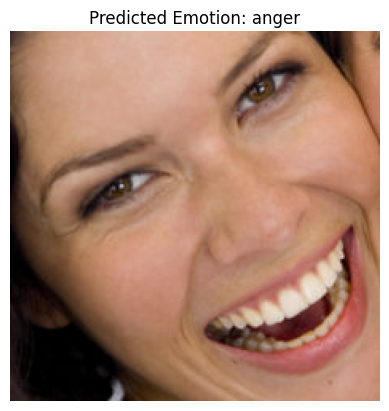

/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


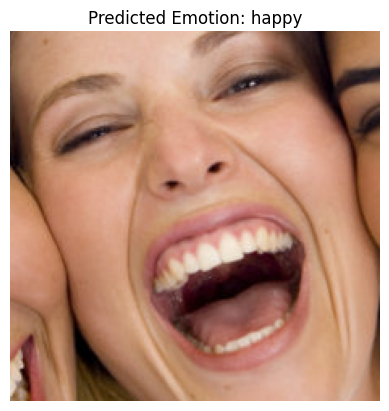

/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


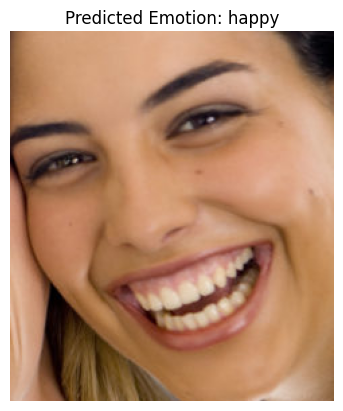

Predicted Emotion: happy


W0000 00:00:1721217866.400267     400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217866.403087     405 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217866.405947     400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


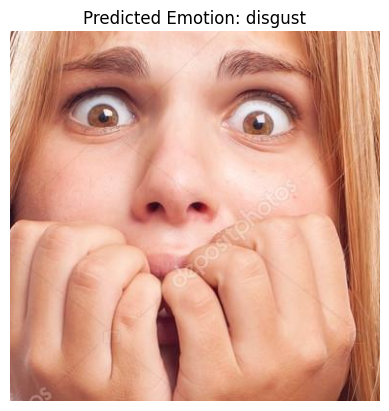

Predicted Emotion: disgust


In [37]:

# Example usage:
image_path = '/kaggle/input/test-img/happy.jpg'  # Replace with your image path
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")

# Example usage:
image_path = '/kaggle/input/test-img/fear.jpg'  # Replace with your image path
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")


W0000 00:00:1721217872.368278     409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217872.371786     413 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721217872.373064     409 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


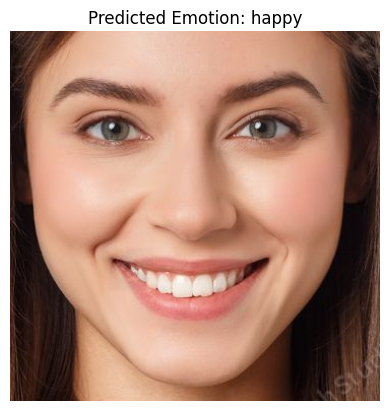

Predicted Emotion: happy


In [38]:
# Example usage:
image_path = '/kaggle/input/smilesmile/smile.jpg'  # Replace with your image path
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")

W0000 00:00:1721224366.829092     885 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721224366.833452     889 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721224366.837324     887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


['contempt']


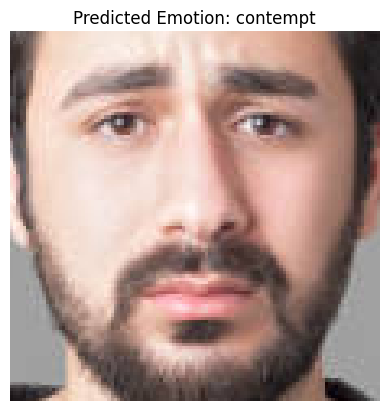

Predicted Emotion: contempt


In [91]:
# Example usage:
image_path = '/kaggle/input/sadsad/sad.jpg'  # Replace with your image path
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")

In [80]:
model= joblib.load("svm_model_with_landmarks.pkl")

W0000 00:00:1721224342.552429     879 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721224342.557539     881 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1721224342.563038     878 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/opt/conda/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


['disgust']


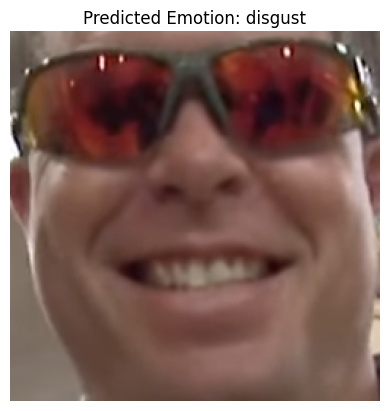

Predicted Emotion: disgust


In [90]:
# Example usage:
image_path = '/kaggle/input/testyo/Capture.PNG'  # Replace with your image path
predicted_emotion = predict_emotion(image_path)
print(f"Predicted Emotion: {predicted_emotion}")